In [14]:
import numpy as np
import matplotlib 
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

import fitsio
import glob

from sklearn.decomposition import SparsePCA

import sys
sys.path.append("../")
import pyrosl

from astropy.convolution import convolve, Gaussian2DKernel
from SPyFFI.Cosmics import cosmicImage

%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['figure.figsize']=(16.0,9.0)    #(6.0,4.0)
matplotlib.rcParams['font.size']=16              #10 
matplotlib.rcParams['savefig.dpi']= 300             #72 
colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']


Populating the interactive namespace from numpy and matplotlib


CPU times: user 2.99 s, sys: 14.6 ms, total: 3 s
Wall time: 3 s


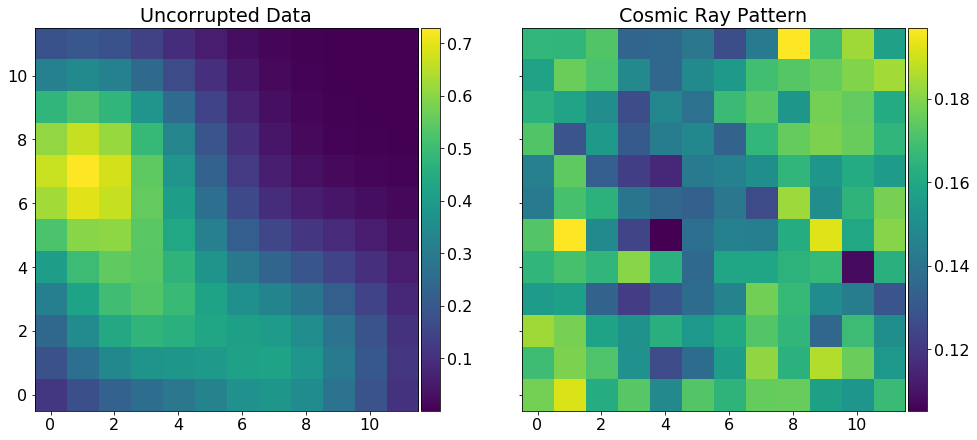

In [15]:
%%time

## use Christina's sample data

from scipy import signal
n_samples = 500
time = np.linspace(0, 8, n_samples)

s1 = np.sin(2 * time)  # Signal 1 : sinusoidal signal
s2 = np.sign(np.sin(3 * time))  # Signal 2 : square signal
s3 = signal.sawtooth(2 * np.pi * time)  # Signal 3: saw tooth signal
nx, ny = 12, 12
dat = np.zeros((500, nx, ny))
dat[:,3,3]=s1
dat[:,7,1]=s2
dat[:,1,7]=s3
for idx, d in enumerate(dat):
    dat[idx] = convolve(d, Gaussian2DKernel(2.5))
# dat += 0.03* np.random.normal(size=dat.shape)
dat /= np.nanmax(dat)
# now add sparse noise in the form of simulated TESS cosmic rays

noise = np.zeros_like(dat)

for j in range(noise.shape[0]):
    cosmic = cosmicImage(size=int(2.**np.ceil(np.log2(max([nx,ny])))),exptime=120.0)
    if np.max(cosmic)>0.:
        cosmic /= np.nanmax(cosmic)
        noise[j,:,:] = cosmic[:nx,:ny]
    
sim = dat+noise

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
im1 = ax1.imshow(np.nanstd(dat,axis=0))
ax1.set_title('Uncorrupted Data')

divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)

f.colorbar(im1,cax=cax)

im2 = ax2.imshow(np.nanstd(noise,axis=0))
ax2.set_title('Cosmic Ray Pattern')

divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.05)

f.colorbar(im2,cax=cax2)


In [16]:
X = sim.reshape((n_samples,nx*ny)) # with noise
# X = dat.reshape((n_samples,nx*ny)) # no noise

# X /= X.max()


In [17]:
# Parameters for ROSL
regROSL = 0.1
estROSL = 10

# Parameters for ROSL+
regROSLp = 0.01
estROSLp = 10
samplesp = (250, 250)


In [18]:
# Run the sub-sampled version
print ' '
full_rosl = pyrosl.ROSL(
    method = 'full',
    rank = estROSL,
    reg = regROSL,
    verbose = True
   )


In [19]:
%%time
loadings, components, E = full_rosl._fit(X)
loadings = loadings[:, :full_rosl.rank_]
model = np.dot(loadings, full_rosl.components_)
sparse = E.reshape(np.shape(dat))
lowrank = model.reshape(np.shape(dat))

print 'Rank found',full_rosl.rank_


Array must be in Fortran-order. Converting now.
Rank found 10
CPU times: user 85.2 ms, sys: 16.7 ms, total: 102 ms
Wall time: 87.6 ms


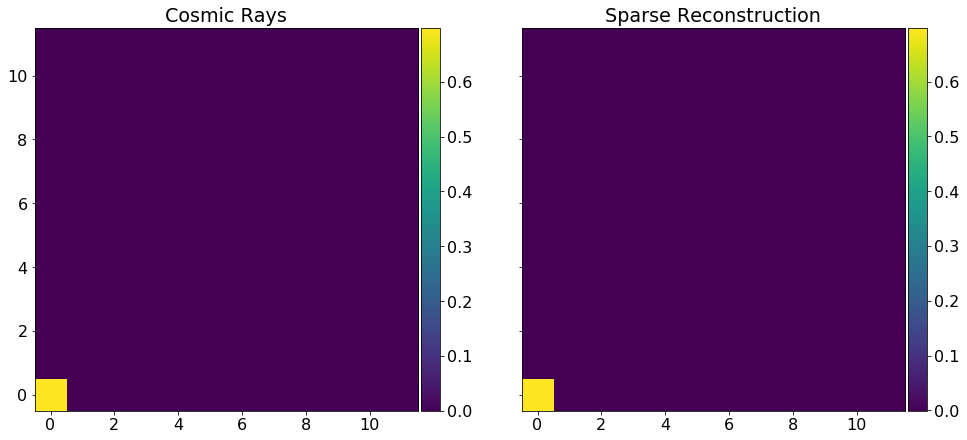

In [20]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
index = 3
im1 = ax1.imshow(noise[index,:,:])
ax1.set_title('Cosmic Rays')
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)

f.colorbar(im1,cax=cax)

im2 = ax2.imshow(sparse[index,:,:])
ax2.set_title('Sparse Reconstruction')
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.05)

f.colorbar(im2,cax=cax2)


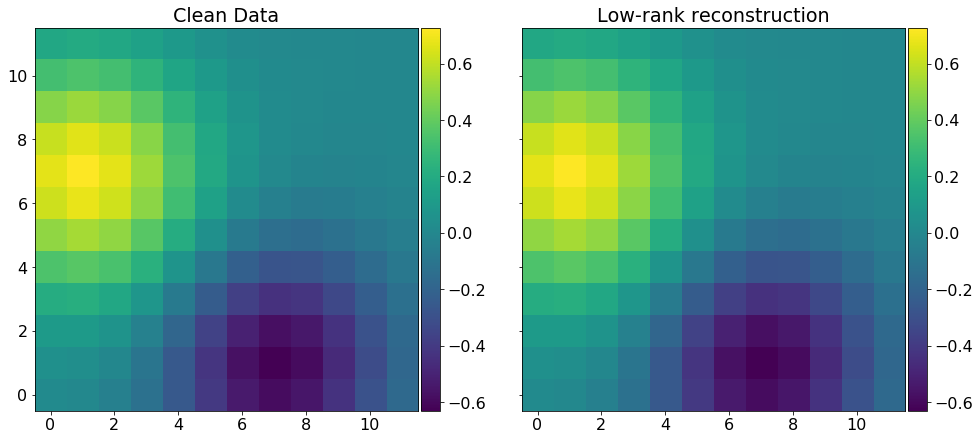

In [21]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
index = 3
im1 = ax1.imshow(dat[index,:,:])
ax1.set_title('Clean Data')

divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)

f.colorbar(im1,cax=cax)

im2 = ax2.imshow(lowrank[index,:,:])
ax2.set_title('Low-rank reconstruction')

divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.05)

f.colorbar(im2,cax=cax2)


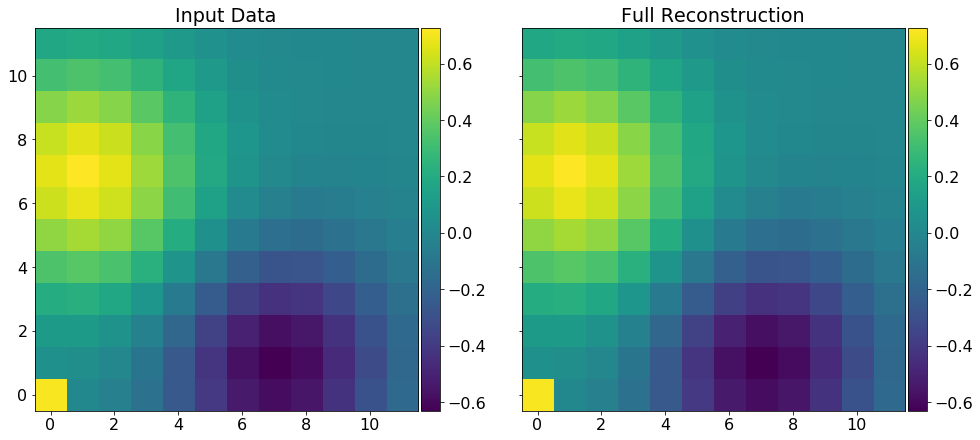

In [22]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
index = 3

im1 = ax1.imshow(sim[index,:,:])
ax1.set_title('Input Data')

divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)

f.colorbar(im1,cax=cax)

im2 = ax2.imshow((sparse+lowrank)[index,:,:])
ax2.set_title('Full Reconstruction')
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.05)

f.colorbar(im2,cax=cax2)


In [29]:
def all_plots(index):

    im1 = ax1.imshow(sim[index,:,:])
    ax1.set_title('Input Data')

    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    f.colorbar(im1,cax=cax)

    im2 = ax2.imshow((sparse)[index,:,:])
    ax2.set_title('Sparse')
    divider2 = make_axes_locatable(ax2)
    cax2 = divider2.append_axes("right", size="5%", pad=0.05)

    f.colorbar(im2,cax=cax2)

    im3 = ax3.imshow((lowrank)[index,:,:])
    ax3.set_title('Low Rank')
    divider3 = make_axes_locatable(ax3)
    cax3 = divider3.append_axes("right", size="5%", pad=0.05)

    f.colorbar(im3,cax=cax3)



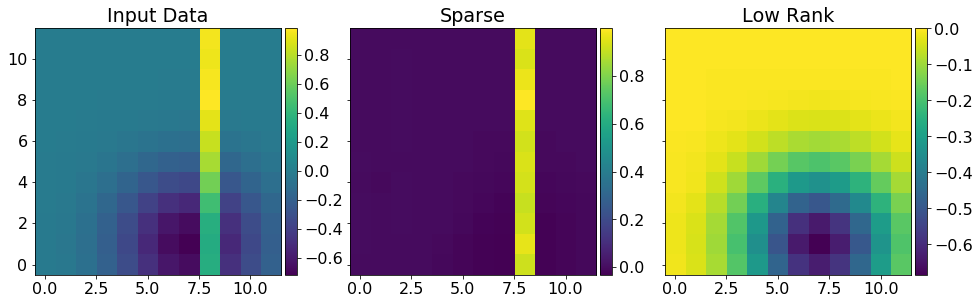

In [25]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)

all_plots(0,f,ax1,ax2,ax3)

In [26]:
import matplotlib.animation as manimation

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='Movie Test', artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=15, metadata=metadata)


In [ ]:
%%time 
plt.rcParams["animation.html"] = "jshtml"
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
fig = (f, ax1, ax2, ax3)

with writer.saving(f, "writer_test.mp4", 25):

    for i in range(n_samples):
        if i % 10 == 0:
            print i 
        all_plots(i)
        writer.grab_frame()
print 'Saved to writer_test.mp4'